In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
# Load the pre-trained model
model = torchvision.models.resnet18(pretrained=True)
model.eval()  

# We only care about cats/dogs 


c:\Users\Daren\anaconda3\envs\torchgpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daren\anaconda3\envs\torchgpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Daren/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform_fn = transforms.Compose([
    transforms.Resize((224, 224)),            
    transforms.ToTensor(),                    
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet training mean, variance
])


In [26]:
def sliding_window(img, stepSize=64, windowSize=(256,256)): # I am setting a big window size based on prior knowledge
    """
    Generate a subgraph patch of size windowSize on img with stepSize as the step.
    """
    for y in range(0, img.shape[0] - windowSize[1], stepSize):
        for x in range(0, img.shape[1] - windowSize[0], stepSize):
            yield (x, y, img[y:y+windowSize[1], x:x+windowSize[0]])


In [ ]:

cat_indices = [282, 283, 284, 285,286] 
dog_indices = list(range(151, 268))  # this is the range of indices for dog classes in ImageNet
from PIL import Image
def is_cat_or_dog(image_patch):
    # First convert numpy format patch to PIL or Tensor
    patch_pil = Image.fromarray(image_patch)
    patch_tensor = transform_fn(patch_pil).unsqueeze(0)  # shape: (1, 3, 224, 224)
    with torch.no_grad():
        outputs = model(patch_tensor)  # shape: (1, 1000)
        probs = torch.softmax(outputs, dim=1)[0]  # (1000,)
    
    cat_prob = probs[cat_indices].max()
    dog_prob = probs[dog_indices].max()

    # Return the predicted species and corresponding probabilities for the patch.
    if cat_prob > dog_prob:
        return 'cat', cat_prob.item()
    else:
        return 'dog', dog_prob.item()

def detect_cat_dog(img_bgr, stepSize=32, winSize=(128,128), prob_threshold=0.5):
    bboxes = []
    for (x, y, patch) in sliding_window(img_bgr, stepSize, winSize):
    
        patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        
        label, score = is_cat_or_dog(patch_rgb)
        if score > prob_threshold:
            bboxes.append((x, y, winSize[0], winSize[1], score, label))
    return bboxes


In [ ]:
def iou(boxA, boxB):
    # box: (x, y, w, h, score, label)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    yB = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou_val = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou_val

def nms(bboxes, iou_threshold=0.3):
    if len(bboxes) == 0:
        return []
    # Sort by score from largest to smallest
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    
    final_bboxes = []
    while len(bboxes) > 0:
        # Take the current highest score box
        best = bboxes[0]
        final_bboxes.append(best)
        # Suppress any frame that overlaps it too much.
        suppressed = []
        for box in bboxes[1:]:
            if iou(best, box) < iou_threshold:
                suppressed.append(box)
        bboxes = suppressed
    return final_bboxes


In [ ]:
def draw_bboxes(img_bgr, bboxes, box_color=(0, 255, 0)):

    out_img = img_bgr.copy()
    for (x, y, w, h, score, label) in bboxes:
        cv2.rectangle(out_img, (x,y), (x+w, y+h), box_color, 2)
        cv2.putText(out_img,
                    f"{label}: {score:.2f}",
                    (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    box_color,
                    1)
    return out_img


Raw detections: 60
After NMS: 4


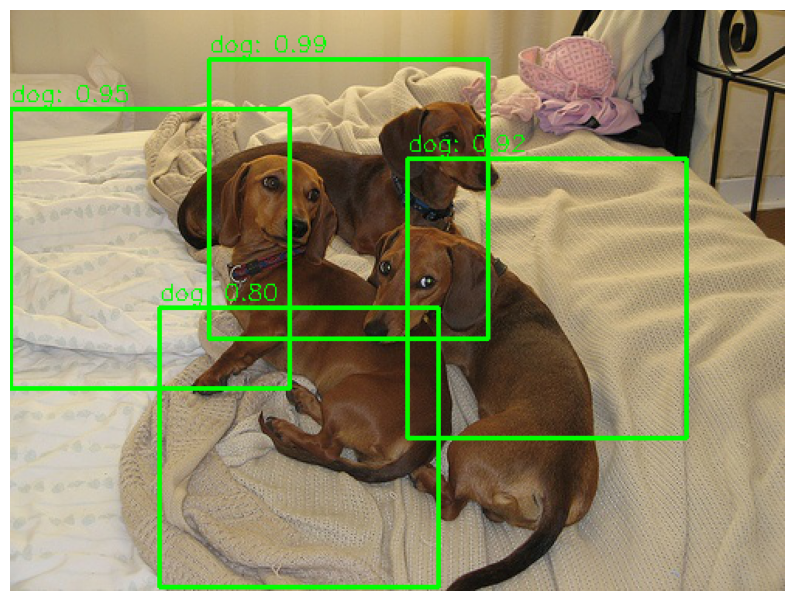

True

In [ ]:
# 读取一张包含猫和狗的图(以OpenCV方式BGR读取)
img_bgr = cv2.imread("2007_001239.jpg")

bboxes = detect_cat_dog(img_bgr, stepSize=32, winSize=(180,180), prob_threshold=0.5)# I am setting a big window size based on prior knowledge
print("Raw detections:", len(bboxes))

bboxes_nms = nms(bboxes, iou_threshold=0.15)# The IOU threshould here is too high (I am just setting it to obtain the best result for this image)
print("After NMS:", len(bboxes_nms))

# 画框
out_img = draw_bboxes(img_bgr, bboxes_nms)
# 显示结果（也可以cv2.imshow()，这里用matplotlib展示）
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 如果需要保存
cv2.imwrite("result_cat_dog.jpg", out_img)


Raw detections: 10
After NMS: 4


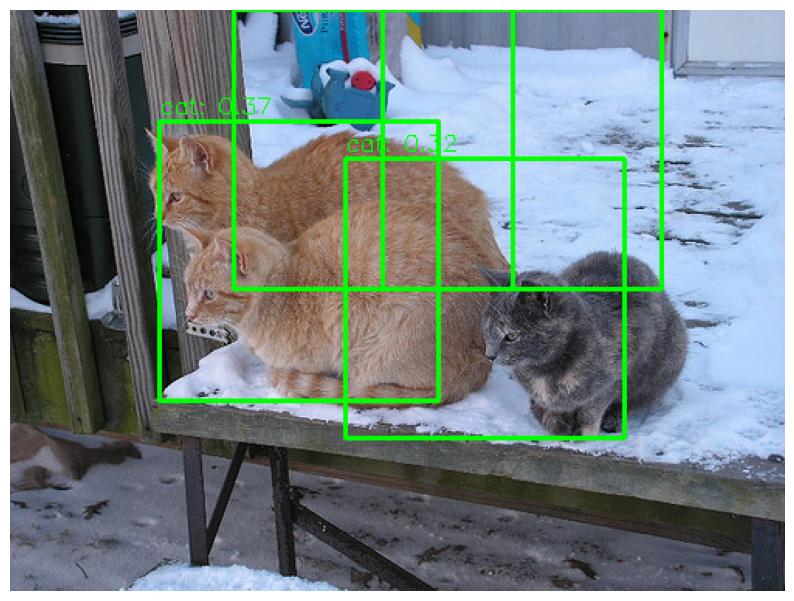

True

In [37]:
# 读取一张包含猫和狗的图(以OpenCV方式BGR读取)
img_bgr = cv2.imread("2008_002152.jpg")

bboxes = detect_cat_dog(img_bgr, stepSize=24, winSize=(180,180), prob_threshold=0.3)# I am setting a big window size based on prior knowledge
print("Raw detections:", len(bboxes))

bboxes_nms = nms(bboxes, iou_threshold=0.4)
print("After NMS:", len(bboxes_nms))

# 画框
out_img = draw_bboxes(img_bgr, bboxes_nms)
# 显示结果（也可以cv2.imshow()，这里用matplotlib展示）
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 如果需要保存
cv2.imwrite("result_cat_dog_2.jpg", out_img)
